# Collecting data

# Table of contents
   [Introduction](#introduction)
1. [Collect ESG Data from Rifinitiv through Eikon API](#esg)
2. [Collect data about S&P500 stocks](#stocks)
3. [Collecting other market data](#market)
4. [Scraping Google trends for ESG terms](#trends_esg)
5. [Scraping Google trends for company names](#trends_c)
6. [Scraping data from newspaper.com](#news)

## Introduction<a name="introduction"></a>

### Sources<a name="sources"></a>

Environmental, Social and Governance (ESG) Scores from Refinitiv [click here](https://www.refinitiv.com/content/dam/marketing/en_us/documents/methodology/refinitiv-esg-scores-methodology.pdf)

Eikon API [click here](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/quick-start)

To see video tutorial on Eikon [click here](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/tutorials)

### Libraries<a name="libraries"></a>

In [27]:
# Imports
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
from datetime import datetime, timedelta
import random
# Retrieve ESG scores
# pip install eikon
import eikon as ek
import re
# Retrieve S&P500 
import requests
from bs4 import BeautifulSoup
import yfinance as yf
# Scraping
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options



## 1. Collect ESG Data from Rifinitiv through Eikon API<a name="esg"></a>

In [473]:
# Setting the key
ek.set_app_key('07d32c81ce424f189172873fec3c1d3b3ea538de')

In [5]:
# Retrieve data
# df, err = ek.get_data("SCREEN(U(IN(Equity(active,public,primary))/*UNV:Public*/), IN(TR.RegCountryCode,""US""), TR.TRESGScore(Period=FY0)>0, CURN=USD)",
#                       ["TR.CUSIP","TR.TickerSymbol","TR.CommonName","TR.RegistrationCountry","TR.TRESGScore.Date","TR.TRESGScore","TR.TRESGScoreGrade",
#                        "TR.EnvironmentPillarScore", "TR.SocialPillarScore", "TR.GovernancePillarScore",
#                        "TR.EnvironmentPillarScoreGrade", "TR.SocialPillarScoreGrade", "TR.GovernancePillarScoreGrade"],
#                       {'SDate':'0', 'EDate':'-15','Period':'FY0','Frq':'FY'})

In [8]:
# Set tickers for all rows

# ins = list(df['Instrument'].unique())
# for i in ins:
#     tempo = df[df['Instrument'] == i]
#     df['Ticker Symbol'][df['Instrument'] == i] = tempo['Ticker Symbol'].iloc[0]

In [9]:
# Set CUSIP for all rows

# for i in ins:
#     tempo = df[df['Instrument'] == i]
#     df['CUSIP'][df['Instrument'] == i] = tempo['CUSIP'].iloc[0]

In [10]:
# Set Company Name for all rows

# for i in ins:
#     tempo = df[df['Instrument'] == i]
#     df['Company Common Name'][df['Instrument'] == i] = tempo['Company Common Name'].iloc[0]

In [11]:
# Set Country of Incorporation for all rows

# for i in ins:
#     tempo = df[df['Instrument'] == i]
#     df['Country of Incorporation'][df['Instrument'] == i] = tempo['Country of Incorporation'].iloc[0]

In [12]:
# Save the dataframe

#df.to_csv('ESG_scores.csv', index = False)

In [538]:
# Importing main dataset after some cleaning
df = pd.read_csv('ESG_scores.csv')

In [539]:
# Selecting only data between 2009 and 2020 
df = df[(df.Date > '2008-12-31T00:00:00Z') & (df.Date < '2021-01-01T00:00:00Z')]
df.reset_index(inplace = True, drop = True)
df.head()

,Instrument,CUSIP,Ticker Symbol,Company Common Name,Country of Incorporation,Date,ESG Score,ESG Score Grade,Environmental Pillar Score,Social Pillar Score,Governance Pillar Score,Environmental Pillar Score Grade,Social Pillar Score Grade,Governance Pillar Score Grade
0,ECL.N,278865100,ECL,Ecolab Inc,United States,2020-12-31T00:00:00Z,76.396235,A-,74.867451,89.474752,56.936266,B+,A,B-
1,ECL.N,278865100,ECL,Ecolab Inc,United States,2019-12-31T00:00:00Z,71.893076,B+,72.852101,84.821631,48.292081,B+,A,C+
2,ECL.N,278865100,ECL,Ecolab Inc,United States,2018-12-31T00:00:00Z,71.100574,B+,70.981378,84.785085,48.123510,B+,A,C+
3,ECL.N,278865100,ECL,Ecolab Inc,United States,2017-12-31T00:00:00Z,67.354841,B+,63.186166,85.466572,44.030179,B,A,C+
4,ECL.N,278865100,ECL,Ecolab Inc,United States,2016-12-31T00:00:00Z,70.787790,B+,65.554546,87.876433,51.077428,B,A,B-


In [540]:
# Information about data
# The dates collected are not the same for all the companies

print(f'The dataset has {df.shape[0]} rows')
print(f'The dataset has {df.shape[1]} columns\n')
print(f'The columns are: {list(df.columns)}\n')
print(f'The number of unique companies is: {len(df["Ticker Symbol"].unique())}')


The dataset has 37715 rows
The dataset has 14 columns

The columns are: ['Instrument', 'CUSIP', 'Ticker Symbol', 'Company Common Name', 'Country of Incorporation', 'Date', 'ESG Score', 'ESG Score Grade', 'Environmental Pillar Score', 'Social Pillar Score', 'Governance Pillar Score', 'Environmental Pillar Score Grade', 'Social Pillar Score Grade', 'Governance Pillar Score Grade']

The number of unique companies is: 3149


## 2. Collect data about S&P500 stocks<a name="stocks"></a>

In [34]:
# Applying web scraping to obtain the list of S&P500 tickers from Wikipedia

URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")
table = soup.find('table').find_all('tr')

stocks = []
for tr in table:
    stocks.append(tr.find('a').text)

stocks = stocks[1:]

print('number of stocks =',(len(stocks))) 

number of stocks = 503


In [35]:
# Downloading data

df_stocks = yf.download(stocks, start = '2009-01-01', end = '2022-11-1')

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found for this date range, symbol may be delisted


In [37]:
# Printing and saving data

df_stocks = df_stocks.sort_values('Date')
df_stocks.to_csv('Stocks.csv')
df_stocks.head()

Adj Close                                                 \
                             A       AAL        AAP      AAPL ABBV        ABC   
Date                                                                            
2009-01-02 00:00:00  10.549064  7.909602  31.565516  2.762747  NaN  14.456063   
2009-01-05 00:00:00  10.906332  7.853037  31.140205  2.879346  NaN  14.732420   
2009-01-06 00:00:00  11.776756  8.541239  31.186430  2.831854  NaN  14.675518   
2009-01-07 00:00:00  11.841717  8.560092  29.947474  2.770662  NaN  14.594235   
2009-01-08 00:00:00  11.919664  9.022037  30.049194  2.822111  NaN  14.923430   

                                                            ...   Volume  \
                      ABMD        ABT      ACGL        ACN  ...     WYNN   
Date                                                        ...            
2009-01-02 00:00:00  16.33  18.571064  7.663333  25.885654  ...  1361400   
2009-01-05 00:00:00  16.00  18.252068  7.597778  26.000973  ...  3101200   
2009-01-06 00:00:00  15.17  17.655691  7.583333  25.678078  ...  3161300   
2009-01-07 00:00:00  14.70  17.558599  7.461111  25.970224  ...  3278200   
2009-01-08 00:00:00  14.28  17.752771  7.586667  25.708826  ...  1616800   

                                                                               \
                         XEL       XOM     XRAY XYL      YUM      ZBH    ZBRA   
Date                                                                            
2009-01-02 00:00:00  2018300  35803700  1574200 NaN  3612149  1147935  559600   
2009-01-05 00:00:00  2908200  43340100  1484200 NaN  6674574   914022  383100   
2009-01-06 00:00:00  3009200  41906100  2324700 NaN  4964340  1611641  298500   
2009-01-07 00:00:00  2523000  35268800  2345400 NaN  5347143  1297491  356900   
2009-01-08 00:00:00  2929700  30817100  1875600 NaN  5097737  1869553  511100   

                                  
                        ZION ZTS  
Date                              
2009-01-02 00:00:00  1956500 NaN  
2009-01-05 00:00:00  1792800 NaN  
2009-01-06 00:00:00  2187500 NaN  
2009-01-07 00:00:00  2796800 NaN  
2009-01-08 00:00:00  2087200 NaN  

[5 rows x 3018 columns]

### Create a new dataset of ESG scores only on companies contained in S&P500

In [614]:
# Creating a new dataset of ESG scores only on companies contained in S&P500

# dataset = df.copy()
# for i in tqdm(range(len(dataset))):
#     if dataset['Ticker Symbol'][i] not in stocks:
#         dataset = dataset.drop(i)

# Saving the final dataset
# dataset.to_csv('ESG_partial.csv', index = False)

In [546]:
# Importing the dataset
dataset = pd.read_csv('ESG_partial.csv')
dataset

,Instrument,CUSIP,Ticker Symbol,Company Common Name,Country of Incorporation,Date,ESG Score,ESG Score Grade,Environmental Pillar Score,Social Pillar Score,Governance Pillar Score,Environmental Pillar Score Grade,Social Pillar Score Grade,Governance Pillar Score Grade
0,ECL.N,278865100,ECL,Ecolab Inc,United States,2020-12-31T00:00:00Z,76.396235,A-,74.867451,89.474752,56.936266,B+,A,B-
1,ECL.N,278865100,ECL,Ecolab Inc,United States,2019-12-31T00:00:00Z,71.893076,B+,72.852101,84.821631,48.292081,B+,A,C+
2,ECL.N,278865100,ECL,Ecolab Inc,United States,2018-12-31T00:00:00Z,71.100574,B+,70.981378,84.785085,48.123510,B+,A,C+
3,ECL.N,278865100,ECL,Ecolab Inc,United States,2017-12-31T00:00:00Z,67.354841,B+,63.186166,85.466572,44.030179,B,A,C+
4,ECL.N,278865100,ECL,Ecolab Inc,United States,2016-12-31T00:00:00Z,70.787790,B+,65.554546,87.876433,51.077428,B,A,B-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5642,OTIS.N,68902V107,OTIS,Otis Worldwide Corp,United States,2013-12-31T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5643,OTIS.N,68902V107,OTIS,Otis Worldwide Corp,United States,2012-12-31T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5644,OTIS.N,68902V107,OTIS,Otis Worldwide Corp,United States,2011-12-31T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5645,OTIS.N,68902V107,OTIS,Otis Worldwide Corp,United States,2010-12-31T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [547]:
print('The new dataset contains:', len(dataset), 'rows\n')
print('The total number of companies from S&P500 is:', len(dataset['Ticker Symbol'].unique()),'\n')
print('Each company has ESG values on:', 7520/470, 'years')

The new dataset contains: 5647 rows

The total number of companies from S&P500 is: 471 

Each company has ESG values on: 16.0 years


In [548]:
# Check which are the 32 excluded stocks for which the API didn't retrieve data

all_stocks = set(stocks)
included = set(list(dataset['Ticker Symbol'].unique()))
excluded_stocks = all_stocks.difference(included)
print(excluded_stocks)

{'ALLE', 'AMCR', 'TEL', 'WTW', 'NCLH', 'IVZ', 'NWS', 'BRK.B', 'ACN', 'ETN', 'AON', 'LYB', 'FOX', 'MDT', 'RCL', 'LIN', 'ACGL', 'PNR', 'SLB', 'NXPI', 'TT', 'OGN', 'RE', 'CB', 'GOOG', 'STX', 'APTV', 'GRMN', 'JCI', 'CEG', 'CCL', 'STE'}


Each of these stocks with the relative Company name has been manually checked if present with alternative names or tickers in the main original dataset, but none of them is included. Therefore, since 32 is a small number of excluded companies we have decided to keep them out and work on the remaining selected 471 firms.

## 3. Collecting other market data<a name="market"></a>

### 3.1 Collecting Bid Price and Ask Price

In [558]:
# Group1 companies Ask Price
a1, erra1 = ek.get_data(list(included)[:150],
                        fields=['TR.ASKPRICE.Date',"TR.ASKPRICE"], 
                        parameters = {'SDate':'2009-01-01','EDate':'2020-1-1','Curn':'USD', 'Frq':'D'})

In [559]:
# Group1 companies Bid Price
b1, errb1 = ek.get_data(list(included)[:150],
                        fields=["TR.BIDPRICE.Date", "TR.BIDPRICE" ], 
                        parameters = {'SDate':'2009-01-01','EDate':'2020-1-1','Curn':'USD', 'Frq':'D'})

In [560]:
# Group 1 dataset with Ask Price and Bid Price
got1 = pd.merge(a1, b1)

# Checking the companies of which we retrieved data
g1 = got1.groupby('Instrument')
result1 = g1.count().rsub(g1.size(), axis=0) # this is to identify companies with null values

# task 1 is composed of companies WITH null values
task1 = result1[(result1['Date'] != 0) | (result1['Ask Price'] != 0) | (result1['Bid Price'] != 0)]

In [565]:
# Group2 companies Ask Price
a2, erra2 = ek.get_data(list(included)[150:400],
                        fields=['TR.ASKPRICE.Date',"TR.ASKPRICE"], 
                        parameters = {'SDate':'2009-01-01','EDate':'2020-1-1','Curn':'USD', 'Frq':'D'})



In [566]:
# Group2 companies Bid Price
b2, errb2 = ek.get_data(list(included)[150:400],
                        fields=["TR.BIDPRICE.Date", "TR.BIDPRICE" ], 
                        parameters = {'SDate':'2009-01-01','EDate':'2020-1-1','Curn':'USD', 'Frq':'D'})

In [567]:
# Group2 dataset with Ask Price and Bid Price
got2 = pd.merge(a2, b2)

# Checking the companies of which we retrieved data
g2 = got2.groupby('Instrument')
result2 = g2.count().rsub(g2.size(), axis=0)

# task 2 is composed of companies WITH null values
task2 = result2[(result2['Date'] != 0) | (result2['Ask Price'] != 0) | (result2['Bid Price'] != 0)]

In [568]:
# Group3 companies Ask Price
a3, erra3 = ek.get_data(list(included)[400:],
                        fields=['TR.ASKPRICE.Date',"TR.ASKPRICE"], 
                        parameters = {'SDate':'2009-01-01','EDate':'2020-1-1','Curn':'USD', 'Frq':'D'})

In [569]:
# Group3 companies Bid Price
b3, errb3 = ek.get_data(list(included)[400:],
                        fields=["TR.BIDPRICE.Date", "TR.BIDPRICE" ], 
                        parameters = {'SDate':'2009-01-01','EDate':'2020-1-1','Curn':'USD', 'Frq':'D'})

In [570]:
# Group3 dataset with Ask Price and Bid Price
got3 = pd.merge(a3, b3)

# Checking the companies of which we retrieved data
g3 = got3.groupby('Instrument')
result3 = g3.count().rsub(g3.size(), axis=0)

# task 3 is composed of companies WITH null values
task3 = result3[(result3['Date'] != 0) | (result3['Ask Price'] != 0) | (result3['Bid Price'] != 0)]

In [571]:
print('Companies of which we DID NOT retrieve spread data:', len(task1) + len(task2) +len(task3))

Companies of which we DID NOT retrieve spread data: 194


In [572]:
# List of companies to exclude
drop_firms = list(task1.index) + list(task2.index) + list(task3.index)

In [573]:
# Exclude companies from group 1
got1.drop(got1[got1.Instrument.isin(drop_firms)].index, inplace=True)

# Exclude companies from group 2
got2.drop(got2[got2.Instrument.isin(drop_firms)].index, inplace=True)

# Exclude companies from group 3
got3.drop(got3[got3.Instrument.isin(drop_firms)].index, inplace=True)

In [574]:
# Dataset with spread data of retrieved companies
spread = pd.concat([got1, got2, got3], ignore_index = True)
spread['Midpoint'] = (spread['Ask Price'] + spread['Bid Price'])/2
spread['Quoted Spread'] = (spread['Ask Price'] - spread['Bid Price'])/spread['Midpoint']
spread

,Instrument,Date,Ask Price,Bid Price,Midpoint,Quoted Spread
0,MA,2009-01-02T00:00:00Z,14.986,14.982,14.984,0.000267
1,MA,2009-01-05T00:00:00Z,15.371,15.306,15.3385,0.004238
2,MA,2009-01-06T00:00:00Z,16.25,16.216,16.233,0.002094
3,MA,2009-01-07T00:00:00Z,15.202,15.152,15.177,0.003294
4,MA,2009-01-08T00:00:00Z,15.314,15.181,15.2475,0.008723
...,...,...,...,...,...,...
766390,CVS,2019-12-30T00:00:00Z,73.72,73.7,73.71,0.000271
766391,CVS,2019-12-31T00:00:00Z,74.27,74.26,74.265,0.000135
766392,CVS,2019-12-31T00:00:00Z,74.27,74.26,74.265,0.000135
766393,CVS,2019-12-31T00:00:00Z,74.27,74.26,74.265,0.000135


In [575]:
# List of companies of which we have spread data
to_keep = list(spread.Instrument.unique())
len(to_keep)

277

### 3.2 Collecting Market Capitalization data

In [549]:
mark_data, errs = ek.get_data(to_keep[:100],
                        fields=['TR.COMPANYMARKETCAPITALIZATION.Date',"TR.COMPANYMARKETCAPITALIZATION"], 
                        parameters = {'SDate':'2009-01-01','EDate':'2020-1-1','Curn':'USD', 'Frq':'D'})

In [550]:
mark_data1, errs1 = ek.get_data(to_keep[100:200],
                        fields=['TR.COMPANYMARKETCAPITALIZATION.Date',"TR.COMPANYMARKETCAPITALIZATION"], 
                        parameters = {'SDate':'2009-01-01','EDate':'2020-1-1','Curn':'USD', 'Frq':'D'})

In [551]:
mark_data2, errs2 = ek.get_data(to_keep[200:],
                        fields=['TR.COMPANYMARKETCAPITALIZATION.Date',"TR.COMPANYMARKETCAPITALIZATION"], 
                        parameters = {'SDate':'2009-01-01','EDate':'2020-1-1','Curn':'USD', 'Frq':'D'})

In [580]:
# Dataset of Market capitalization data of retrieved companies
market_cap = pd.concat([mark_data, mark_data1, mark_data2], ignore_index = True)
market_cap

,Instrument,Date,Company Market Capitalization
0,MA,2009-01-02T00:00:00Z,19356676158.779999
1,MA,2009-01-05T00:00:00Z,19806410656.259998
2,MA,2009-01-06T00:00:00Z,20938500943.02
3,MA,2009-01-07T00:00:00Z,19652622135.57
4,MA,2009-01-08T00:00:00Z,19744378311.779999
...,...,...,...
766731,CVS,2019-12-24T00:00:00Z,96934828161.570007
766732,CVS,2019-12-26T00:00:00Z,96895799241.360001
766733,CVS,2019-12-27T00:00:00Z,96791722120.800003
766734,CVS,2019-12-30T00:00:00Z,95881047315.899994


##### Check missing values

In [576]:
nn2 = market_cap.groupby('Instrument')
r_nn2 = nn2.count().rsub(nn2.size(), axis=0)

# task 2 is composed of companies WITH null values
com_n2 = r_nn2[(r_nn2['Date'] != 0) | (r_nn2['Company Market Capitalization'] != 0) ]
com_n2

,Date,Company Market Capitalization
Instrument,,
FIS,0,1265


In [584]:
# Drop FIS from market capitalization data and from spread data since we have missing values
market_cap.drop(market_cap[market_cap.Instrument == 'FIS'].index, inplace=True)
spread.drop(spread[spread.Instrument == 'FIS'].index, inplace=True)

In [586]:
# Final dataset with market data
market = pd.merge(spread, market_cap, left_on=['Instrument', 'Date'], right_on=['Instrument', 'Date'])
market.rename({'Instrument':'Ticker Symbol'}, axis = 1, inplace = True)
market

,Ticker Symbol,Date,Ask Price,Bid Price,Midpoint,Quoted Spread,Company Market Capitalization
0,MA,2009-01-02T00:00:00Z,14.986,14.982,14.984,0.000267,19356676158.779999
1,MA,2009-01-05T00:00:00Z,15.371,15.306,15.3385,0.004238,19806410656.259998
2,MA,2009-01-06T00:00:00Z,16.25,16.216,16.233,0.002094,20938500943.02
3,MA,2009-01-07T00:00:00Z,15.202,15.152,15.177,0.003294,19652622135.57
4,MA,2009-01-08T00:00:00Z,15.314,15.181,15.2475,0.008723,19744378311.779999
...,...,...,...,...,...,...,...
763626,CVS,2019-12-30T00:00:00Z,73.72,73.7,73.71,0.000271,95881047315.899994
763627,CVS,2019-12-31T00:00:00Z,74.27,74.26,74.265,0.000135,96648616080.029999
763628,CVS,2019-12-31T00:00:00Z,74.27,74.26,74.265,0.000135,96648616080.029999
763629,CVS,2019-12-31T00:00:00Z,74.27,74.26,74.265,0.000135,96648616080.029999


### 3.3 Create final dataset of ESG scores on the basis of retrieved market data

In [610]:
to_keep = list(market['Ticker Symbol'].unique())
len(companies)

276

In [611]:
# Keeping only data from 2009 to 2021 and for companies of which we have all market data. 
# We remove also those companies that have some missing values in the ESG scores (to_exclude_with_na)

esg = dataset.copy()
for i in tqdm(range(len(esg))):
    if (esg['Ticker Symbol'][i] not in to_keep):
        esg = esg.drop(i)
esg.reset_index(inplace = True, drop = True)

100%|██████████| 5647/5647 [00:02<00:00, 2483.92it/s]


In [612]:
# Checking for last companies with null values
filt = esg.groupby('Ticker Symbol').count()['ESG Score']
filt= filt[filt <11]
to_exclude_with_na = list(filt.keys())
len(to_exclude_with_na)

13

In [613]:
# We can observe that there are some companies that present null ESG scores in some years, so we keep only those that have
# at least esg scores 11 times (11 years)

for i in tqdm(range(len(esg))):
    if (esg['Ticker Symbol'][i] in to_exclude_with_na):
        esg = esg.drop(i)
esg.reset_index(inplace = True, drop = True)
esg.to_csv('ESG_final.csv')
esg

100%|██████████| 3307/3307 [00:00<00:00, 17284.32it/s]


,Instrument,CUSIP,Ticker Symbol,Company Common Name,Country of Incorporation,Date,ESG Score,ESG Score Grade,Environmental Pillar Score,Social Pillar Score,Governance Pillar Score,Environmental Pillar Score Grade,Social Pillar Score Grade,Governance Pillar Score Grade
0,ECL.N,278865100,ECL,Ecolab Inc,United States,2020-12-31T00:00:00Z,76.396235,A-,74.867451,89.474752,56.936266,B+,A,B-
1,ECL.N,278865100,ECL,Ecolab Inc,United States,2019-12-31T00:00:00Z,71.893076,B+,72.852101,84.821631,48.292081,B+,A,C+
2,ECL.N,278865100,ECL,Ecolab Inc,United States,2018-12-31T00:00:00Z,71.100574,B+,70.981378,84.785085,48.123510,B+,A,C+
3,ECL.N,278865100,ECL,Ecolab Inc,United States,2017-12-31T00:00:00Z,67.354841,B+,63.186166,85.466572,44.030179,B,A,C+
4,ECL.N,278865100,ECL,Ecolab Inc,United States,2016-12-31T00:00:00Z,70.787790,B+,65.554546,87.876433,51.077428,B,A,B-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3146,PM.N,718172109,PM,Philip Morris International Inc,United States,2013-12-31T00:00:00Z,60.839452,B,61.547546,55.272797,69.678490,B,B-,B+
3147,PM.N,718172109,PM,Philip Morris International Inc,United States,2012-12-31T00:00:00Z,62.985173,B,64.400437,61.959435,63.200631,B,B,B
3148,PM.N,718172109,PM,Philip Morris International Inc,United States,2011-12-31T00:00:00Z,65.951644,B,65.814394,68.679577,61.389357,B,B+,B
3149,PM.N,718172109,PM,Philip Morris International Inc,United States,2010-12-31T00:00:00Z,47.726856,C+,56.060606,55.262951,25.539035,B-,B-,C-


## 4. Scraping Google trends for ESG terms<a name="trends_esg"></a>

We scrape the search volumes for different terms divided in four categories: ESG, environment, social, and governance. The terms are the same as the ones considered in the paper "Do sustainable company stock prices increase with ESG scrutiny? Evidence using social media", according to which they are based on the metrics within each score formulated by Refinitiv.

In [1]:
ESG_kw = ['CSR','ESG', 'ESG investing', 'ESG screening', 'Ethical investing', 'Green investments',
          'Impact investing', 'Responsible investing', 'Responsible investments',
          'Socially responsible investing', 'Sustainability', 'Sustainable', 'Sustainable investments']

environment_kw = ['Acid rain', 'Biodiversity', 'Carbon footprint', 'Climate change', 'Conservation',
                  'Deforestation', 'Endangered species', 'Environment', 'Global warming', 'Globalization',
                  'Greenhouse gas', 'Ozone layer', 'Pollution', 'Renewable energy']

social_kw = ['Animal testing', 'Business disabilities', 'Business ethnicity', 'Career development',
             'Child labor', 'Customer complaints', 'Data privacy', 'Equal rights', 'Equality',
             'Fair trade', 'Gender equality', 'Health and safety', 'Human rights', 'Inequality',
             'Labor practices', 'LGBT business', 'Product quality', 'Salary gap', 'Social impact',
             'Social responsibility', 'Social rights', 'Staff turnover', 'Work life balance',
             'Working conditions']

governance_kw = ['Board composition', 'Board members', 'Board of directors', 'Code of business conduct',
                 'Company polices', 'Company transparency', 'Corporate compliance', 'Corporate fraud',
                 'Corporate governance', 'CSR strategy', 'Executive compensation', 'Litigation risk',
                 'Management structure', 'Public disclosure', 'Risk management', 'Shareholder rights',
                 'Shareholders interest', 'Sustainable governance', 'Sustainable growth', 'Takeover defenses', 
                 'Tax reporting', 'Whistleblower']

In [2]:
# functions for scraping

def build_url(timeframe, keyword, geo = 'US'):
    """
    Takes a time frame (as string), a keyword and a geographic setting and returns the URL of the
    corresponding Google Trends page
    """
    return f'https://trends.google.com/trends/explore?date={timeframe}&geo={geo}&q={keyword}'

def download_trends(url, driver):
    """
    Takes a url and a driver and downloads a csv file of the google trend page
    """
    driver.get(url) # get the page
    time.sleep(2) # wait for the website to load
    
    attempt = 0
    button = None
    while attempt < 5: # try 5 times to find the download button
        try:
            button = driver.find_element_by_xpath('/html/body/div[3]/div[2]/div/md-content/div/div/div[1]/trends-widget/ng-include/widget/div/div/div/widget-actions/div/button[1]/i')
            attempt = 5
        except:
            if attempt == 4:
                print('failed for url:', url) # print failed if max number of tries is exceeded
            driver.get(url) # if failed re-load the page
            time.sleep(2) # wait for the website to load
            attempt += 1
    if button != None:
        attempt = 0
        while attempt < 5: # try 5 times to click on the button
            try:
                button.click()
                attempt = 5
            except:
                attempt += 1
                
def build_driver(download_dir = None):
    """
    Builds a browser environment. If a download directory path is given, it sets it as the
    default download directory
    """
    options = webdriver.ChromeOptions()
    options.add_argument("--start-maximized")
    if download_dir != None:
        prefs = {"profile.default_content_settings.popups": 0,
                 "download.default_directory": download_dir + os.path.sep, # IMPORTANT - ENDING SLASH V IMPORTANT
                 "directory_upgrade": True}
        options.add_experimental_option("prefs", prefs)
    return webdriver.Chrome(ChromeDriverManager().install(), options = options)

### 4.1 Daily data

Google Trends limits the retrieval of daily values to a batch of nine months. Hence, to obtain daily values for the entire time period for each term we have to:
- collect daily values (in intervals of eight months)
- collect monthly values for each month
- weight the daily search volume is by its monthly value, thus creating comparable daily values for the entire time period in the range 0 to 100

In [6]:
# building a list of time frames, each eight-month long
times = []

starting = datetime(2009, 1, 1) # starting date
increment = 8 # month interval
last_date = datetime(2019, 12, 31)
while starting < last_date:
    year = starting.year + (starting.month + increment - 1) // 12 # year of next starting date
    month = (starting.month + increment - 1) % 12 + 1 # month of next starting date
    next_starting = datetime(year, month, 1) # next starting date
    after8months = next_starting - timedelta(days = 1) # ending date of thsi period
    if after8months > last_date:
        after8months = last_date
    times.append(starting.strftime('%Y-%m-%d')+' '+after8months.strftime('%Y-%m-%d'))
    starting = next_starting

In [7]:
# set keywords
keywords = (ESG_kw + environment_kw + social_kw + governance_kw)

The code below was run in multiple batches, because even with the sleeping time added, the code would sometimes get blocked because of too many requests. We do not recommend running it, it is very time consuming. We provide the obtained csv files to be loaded in the cells below.

In [ ]:
# for i, w in enumerate(keywords):
#     if i%3 == 0 and i != 0:
#         time.sleep(random.randint(60, 120))
#     if i%7 == 0 and i%3 != 0 and i != 0:
#         time.sleep(random.randint(300, 600))
        
#     # create download directory for the specific keyword
#     os.mkdir(os.path.join(os.getcwd(), 'trends', 'daily',w.replace(" ", "_")))
    
#     # create browser
#     driver = build_driver(os.path.join(os.getcwd(), 'trends', 'daily',w.replace(" ", "_")))
    
#     # loop on all time intervals
#     for t in times:
#         url = build_url(t, w)
#         download_trends(url, driver) # download trend csv

In [8]:
def format_df(df, w):
    """
    Function to properly load the saved csv files. Takes a dataframe and its corresponding keyword
    """
    if df.columns[0] == 'Giorno':
        df = df.set_index('Giorno')
        df.index.name = 'Day'
        df = df.rename(columns = {f'{w}: (Stati Uniti)':f'{w}_daily'})
    else:
        df = df.set_index('Day')
        df = df.rename(columns = {f'{w}: (United States)':f'{w}_daily'})
    return df

In [13]:
daily = pd.DataFrame()

for w in keywords: # loop over all keywords
    daily_word = pd.read_csv(os.getcwd()+f'/trends/daily/{w.replace(" ", "_")}/multiTimeline.csv', header = 1)
    daily_word = format_df(daily_word, w) # load and format the first dataframe

    for i in range(1, len(times)): # loop over all time intervals
        new_df = pd.read_csv(os.getcwd()+f'/trends/daily/{w.replace(" ", "_")}/multiTimeline ({i}).csv', header = 1)
        new_df = format_df(new_df, w) # load and format the df
        
        daily_word = pd.concat([daily_word, new_df]) # concat each df ater the other
        
    daily = pd.concat([daily, daily_word], axis = 1) # add the new df as a column of the total df

daily['Whistleblower_daily'] = daily['Whistleblower_daily'].replace('< 1',0)
daily['Whistleblower_daily'] = daily['Whistleblower_daily'].astype(int)
daily.head()

,CSR_daily,ESG_daily,ESG investing_daily,ESG screening_daily,Ethical investing_daily,Green investments_daily,Impact investing_daily,Responsible investing_daily,Responsible investments_daily,Socially responsible investing_daily,...,Management structure_daily,Public disclosure_daily,Risk management_daily,Shareholder rights_daily,Shareholders interest_daily,Sustainable governance_daily,Sustainable growth_daily,Takeover defenses_daily,Tax reporting_daily,Whistleblower_daily
Day,,,,,,,,,,,,,,,,,,,,,
2009-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,56,0,0,0,0,0,0,0
2009-01-02,0,0,0,0,0,0,23,0,0,10,...,0,0,46,0,0,0,82,0,22,0
2009-01-03,33,0,0,0,0,26,0,0,39,0,...,34,0,18,41,0,0,0,0,0,0
2009-01-04,33,0,0,0,0,0,0,38,0,13,...,0,0,20,0,0,0,0,0,20,0
2009-01-05,44,33,0,0,0,0,0,0,0,0,...,0,0,54,43,0,12,0,23,0,31


### 4.2 Monthly data

The code below was run in multiple batches, because even with the sleeping time added, the code would sometimes get blocked because of too many requests. We do not recommend running it, it is very time consuming. We provide the obtained csv files to be loaded in the cells below.

In [ ]:
# for i, w in enumerate(keywords):
#     # create download directory for the specific keyword
#     os.mkdir(os.path.join(os.getcwd(), 'trends', 'monthly',w.replace(" ", "_")))
    
#     # create browser
#     driver = build_driver(os.path.join(os.getcwd(), 'trends', 'monthly',w.replace(" ", "_")))
    
#     # build urls
#     url = build_url('2009-01-01 2019-12-31', w)
#     download_trends(url, driver)
    
#     if i%7 == 0 and i != 0:
#         time.sleep(random.randint(300, 600))
#     if i%3 == 0 and i%7 != 0 and i !=0:
#         time.sleep(random.randint(30, 60))
#     else:
#         time.sleep(random.randint(10, 30))

In [10]:
monthly = pd.DataFrame()

for w in keywords: # loop over all keywords
    monthly_word = pd.read_csv(os.getcwd()+f'/trends/monthly/{w.replace(" ","_")}/multiTimeline.csv', 
                               header = 1, index_col ='Month') # load the df
    monthly_word = monthly_word.rename(columns = {f'{w}: (United States)':f'{w}_monthly'}) # format the df
      
    monthly = pd.concat([monthly, monthly_word], axis = 1) # add new df as a column of the total df
    
monthly.head()

,CSR_monthly,ESG_monthly,ESG investing_monthly,ESG screening_monthly,Ethical investing_monthly,Green investments_monthly,Impact investing_monthly,Responsible investing_monthly,Responsible investments_monthly,Socially responsible investing_monthly,...,Management structure_monthly,Public disclosure_monthly,Risk management_monthly,Shareholder rights_monthly,Shareholders interest_monthly,Sustainable governance_monthly,Sustainable growth_monthly,Takeover defenses_monthly,Tax reporting_monthly,Whistleblower_monthly
Month,,,,,,,,,,,,,,,,,,,,,
2009-01,38,44,0,0,0,89,31,100,46,61,...,59,65,86,100,45,27,36,0,64,4
2009-02,41,28,0,0,0,65,0,77,0,58,...,75,57,93,35,0,0,51,0,100,5
2009-03,40,48,0,0,64,98,0,61,0,54,...,89,79,88,11,51,0,57,88,74,5
2009-04,41,41,0,0,59,68,19,56,41,31,...,79,64,94,51,0,0,32,41,78,4
2009-05,35,36,0,0,0,27,15,37,0,0,...,71,81,83,85,0,0,14,0,28,4


### 4.3 Creating weighted ESG search volumes

In [14]:
# build a df that containes weights for each keyword
weights = monthly/100 # compute weights
weights = weights.rename(columns=lambda x: x[:-7]+'weights')

# add 'month' column to the monthly df for the join
weights['month'] = weights.index

# add 'month' column to the daily df for the join
daily['month'] = daily.index
daily['month'] = daily['month'].apply(lambda x: x[:7])

In [15]:
# join the daily df with the weights df
weighted = pd.merge(weights, daily, on = 'month', how = 'outer')
weighted.index = daily.index
weighted = weighted.drop(columns = ['month'])

# build a df with the weighted search volumes
results = pd.DataFrame()
for w in keywords:
    new_col = weighted[w+'_weights']*weighted[w+'_daily']
    new_col.name = w
    results = pd.concat([results, new_col], axis = 1)
    
results.head()

,CSR,ESG,ESG investing,ESG screening,Ethical investing,Green investments,Impact investing,Responsible investing,Responsible investments,Socially responsible investing,...,Management structure,Public disclosure,Risk management,Shareholder rights,Shareholders interest,Sustainable governance,Sustainable growth,Takeover defenses,Tax reporting,Whistleblower
2009-01-01,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,48.16,0.0,0.0,0.00,0.00,0.0,0.00,0.00
2009-01-02,0.00,0.00,0.0,0.0,0.0,0.00,7.13,0.0,0.00,6.10,...,0.00,0.0,39.56,0.0,0.0,0.00,29.52,0.0,14.08,0.00
2009-01-03,12.54,0.00,0.0,0.0,0.0,23.14,0.00,0.0,17.94,0.00,...,20.06,0.0,15.48,41.0,0.0,0.00,0.00,0.0,0.00,0.00
2009-01-04,12.54,0.00,0.0,0.0,0.0,0.00,0.00,38.0,0.00,7.93,...,0.00,0.0,17.20,0.0,0.0,0.00,0.00,0.0,12.80,0.00
2009-01-05,16.72,14.52,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,46.44,43.0,0.0,3.24,0.00,0.0,0.00,1.24


The search volume for each topic is constructed taking the average of all included search term’s (weighted) daily values.

In [16]:
# divide the results by topic
results_ESG = results[ESG_kw].copy()
results_env = results[environment_kw].copy()
results_soc = results[social_kw].copy()
results_gov = results[governance_kw].copy()

aux_l = [results_ESG, results_env, results_soc, results_gov]

for el in aux_l:
    el['tot'] = el.sum(axis = 1)/len(el.columns)

In [17]:
# store the four results in a unique datafram
search_volumes_esg = pd.DataFrame()
search_volumes_esg['ESG'] = results_ESG['tot']
search_volumes_esg['Environment'] = results_env['tot']
search_volumes_esg['Social'] = results_soc['tot']
search_volumes_esg['Governance'] = results_gov['tot']

search_volumes_esg.head()

,ESG,Environment,Social,Governance
2009-01-01,3.166154,9.227857,3.899167,3.664091
2009-01-02,4.008462,11.831429,8.912083,6.791818
2009-01-03,7.281538,13.157857,5.140000,8.665000
2009-01-04,7.340769,9.617143,10.724583,2.734545
2009-01-05,8.163077,18.562857,8.952917,11.808636


In [18]:
# search_volumes_esg.to_csv('ESG_trends.csv')

## 5. Scraping Google trends for company names<a name="trends_c"></a>

We consider search volumes on company names to capture public attention to individual companies.

In [19]:
companies_tickers = ['MA', 'TGT', 'PNC', 'YUM', 'LH', 'NEM', 'KMX', 'PXD', 'GWW', 'BXP', 'MSI', 'RTX', 'BDX',
 'AFL', 'NI', 'MAA', 'SYY', 'K', 'IP', 'D', 'CAG', 'MET', 'RSG', 'ICE', 'MS', 'IEX', 'CPT', 'ADM',
 'BWA', 'FMC', 'EMN', 'IPG', 'URI', 'AAP', 'ALL', 'EL', 'MCD', 'CE', 'ZBH', 'OXY', 'TYL', 'HAL',
 'VTR', 'TXT', 'EXR', 'PKG', 'KO', 'APH', 'TMO', 'DOV', 'GL', 'JPM', 'DAL', 'PNW', 'FDS', 'DXC',
 'PPG', 'CI', 'FE', 'PHM', 'KIM', 'EFX', 'IFF', 'MKC', 'DIS', 'CMG', 'VMC', 'BBY', 'PKI', 'DPZ',
 'CF', 'ROP', 'DHR', 'MOS', 'STT', 'OMC', 'MGM', 'AVB', 'V', 'DLR', 'AES', 'VLO', 'MOH', 'PG',
 'NEE', 'SYK', 'SPG', 'IBM', 'F', 'UNP', 'KEY', 'EQR', 'SRE', 'HWM', 'DFS', 'TAP', 'BKR', 'MHK',
 'AME', 'ABT', 'CRL', 'PPL', 'WST', 'IRM', 'O', 'ES', 'J', 'LEN', 'MO', 'NUE', 'GD', 'PWR', 'AVY',
 'DTE', 'HIG', 'CAT', 'NOC', 'ECL', 'BAC', 'AEE', 'WMB', 'BR', 'ABC', 'HUM', 'LNC', 'BAX', 'VFC',
 'TFC', 'VZ', 'L', 'ALK', 'TFX', 'FIS', 'ALB', 'JNJ', 'CPB', 'BSX', 'VNO', 'AMT', 'MRK', 'BMY',
 'C', 'RJF', 'HES', 'LVS', 'PH', 'ITW', 'GLW', 'BK', 'EMR', 'DE', 'WRB', 'ELV', 'RF', 'UNH', 'IT',
 'HSY', 'UHS', 'CL', 'DUK', 'PFE', 'GPN', 'RHI', 'BEN', 'BRO', 'CLX', 'XOM', 'CNC', 'PEG', 'PSA',
 'NRG', 'HD', 'AXP', 'RL', 'UDR', 'ED', 'AIZ', 'NKE', 'SWK', 'CVX', 'WY', 'COP', 'WHR', 'FCX',
 'COF', 'GIS', 'MCO', 'PLD', 'EOG', 'MMM', 'SEE', 'CHD', 'PGR', 'MTB', 'STZ', 'HRL', 'FDX', 'PRU',
 'MTD', 'ATO', 'DHI', 'BIO', 'TDG', 'NVR', 'AMP', 'SJM', 'EIX', 'LUV', 'DVA', 'MLM', 'AOS', 'AZO',
 'MMC', 'SHW', 'GS', 'KMB', 'USB', 'FRT', 'DVN', 'CMS', 'UPS', 'LHX', 'LLY', 'TPR', 'LOW',
 'LMT', 'ROK', 'T', 'SO', 'MRO', 'ESS', 'MCK', 'HPQ', 'WAT', 'NSC', 'TDY', 'SNA', 'CCI', 'CNP',
 'RMD', 'BA', 'GPC', 'CMI', 'OKE', 'A', 'CAH', 'CRM', 'LYV', 'ROL', 'PM', 'WAB', 'WM', 'CMA', 'GE',
 'APD', 'PCG', 'AJG', 'COO', 'EW', 'MAS', 'TRV', 'ETR', 'TJX', 'AWK', 'BLK', 'DRI', 'KR', 'AIG',
 'DGX', 'WFC', 'HON', 'ARE', 'WMT', 'TSN', 'EQT', 'WEC', 'CVS']

In [21]:
def ticker(ticker_list):
    companies = []
    for ticker in ticker_list:
        stock = yf.Ticker(ticker)
        name = stock.info.get('longName')
        companies.append(name)
    return companies

# get the name of each company from its ticker
companies = ticker(companies_tickers)

In [22]:
# clean the name
to_remove = ['Inc.','International','Global','Group','Corp.','Corporation','Incorporated', 'Company','Inc', 
             'The ', ',','!', '&','Co.']

companies_clean = []
for c in companies:
    for s in to_remove:
        c = c.replace(s, '')
    companies_clean.append(" ".join(c.split()))
    
# build dictionaries to get from keywords to ticker and viceversa
name_to_ticker = dict(zip(companies_clean, companies_tickers))
ticker_to_name = dict(zip(companies_tickers, companies_clean))

In [23]:
def get_company_kw(driver):
    """
    Gets the keyword for each company, by selecting the autocomplete suggestion that containes the 
    word 'company'. It saves the last part of the url, which can be used as a keyword
    """
    # find and click on the search bar
    bar = driver.find_elements_by_id('input-25') 
    bar[0].click()
    time.sleep(0.5)
    
    # get autocomplete suggestions objects and their texts
    suggestions = driver.find_elements_by_class_name('autocomplete-entity.autocomplete-desc')
    topics = [i.text for i in suggestions]
    
    # find one option that contains 'company'
    to_click = None
    for i, el in enumerate(topics):
        if 'company' in el or 'Company' in el:
            to_click = i
            break
    if to_click == None:
        return None
    
    # click on the suggestion found above
    suggestions[to_click].click()
    time.sleep(2)
    
    # get the new url
    url = driver.current_url
    
    # return last part of the url
    return re.findall(r'q=(.*)', url)[0]

### 5.1 Scrape the data

For searches on company names, we consider weekly values due to low daily search volumes. Google Trends limits retrieval to batches of five years. We retrieve the data in batches of 4/5 years with one overlapping year for each. We then use the overlapping year to match the values and create a common scale.

In [24]:
# timeframes
times = ['2009-01-01 2012-12-31','2012-01-01 2015-12-31','2015-01-01 2019-12-31']

We use the name of the company as an input in the search bar, and from there we find the suggestion wich refers to the company. We will then use the retrieved keyword to find and download the data.

In [ ]:
# trends_kw = dict() # dictionary for storage

# # build a browser
# driver = build_driver()

# for i, w in enumerate(companies_clean): # loop over company names
#     url = build_url(times[0], w) # note that the timeframe chosen does not matter
#     driver.get(url) # load the page
#     if 'Error 429 (Too Many Requests)' in driver.page_source: # if there's an errore try again
#         driver.get(url)
#     time.sleep(2) # wait for the page to load
    
#     kw = get_company_kw(driver) # get the keyword
    
#     trends_kw[w] = kw # save the keyword found
    
#     if i%20 == 0 and i != 0:
#         time.sleep(random.randint(10, 30))
#     if i%5 == 0 and i%20 != 0 and i !=0:
#         time.sleep(random.randint(5, 10))
#     else:
#         time.sleep(random.randint(2,3))

In [ ]:
# manually adjust some keywords
# correct = ['%2Fm%2F02v0s5', '%2Fm%2F01qxj3','%2Fm%2F03p3g1n','%2Fm%2F0h4xyv','%2Fm%2F0k9ts','%2Fm%2F02twsr',
#  '%2Fm%2F06m_p2', '%2Fm%2F0cq0_b', '%2Fm%2F01kqjn', '%2Fm%2F03br8l4', '%2Fm%2F03p2ps4', '%2Fm%2F07j0sp',
# '%2Fm%2F0gl3d_', '%2Fm%2F03d7yqj', '%2Fm%2F02z70xs', '%2Fm%2F07y_vs', '%2Fm%2F01n7kh', '%2Fm%2F0168nq',
# '%2Fm%2F06l76d', '%2Fm%2F01l4jh', '%2Fg%2F1tf6n07l', '%2Fm%2F03p3dks', '%2Fm%2F01vc1k', '%2Fm%2F04c_q_',
# '%2Fm%2F0gztl', '%2Fm%2F037922', '%2Fm%2F08z129', '%2Fm%2F01c48j', '%2Fg%2F1vg_89qc', '%2Fm%2F042x1n',
# '%2Fm%2F0cm4qm','%2Fm%2F03p2lwn','%2Fm%2F02l48d']

# i = 0
# for k,v in trends_kw.items():
#     if v == None:
#         trends_kw[k] = correct[i]
#         i += 1

In [ ]:
# # set keywords
# keywords = companies_clean

# for i, w in enumerate(keywords):
#     ticker = name_to_ticker[w]
    
#     # create download directory for the specific keyword
#     os.mkdir(os.path.join(os.getcwd(), 'trends', 'companies', ticker))
    
#     # create browser
#     driver = build_driver(os.path.join(os.getcwd(), 'trends', 'companies', ticker))
    
#     # get the keyword
#     w = trends_kw[w]
    
#     # loop on all time intervals
#     for t in times:
#         url = build_url(t, w)
#         download_trends(url, driver) # download trend csv
        
#     if i%20 == 0 and i != 0:
#         time.sleep(random.randint(120, 600))
#     if i%7 == 0 and i%20 != 0 and i !=0:
#         time.sleep(random.randint(30, 120))
#     else:
#         time.sleep(random.randint(2, 15))

### 5.2 Standardize the data across periods

In [25]:
def standardize_df(one, two):
    """
    Take two dataframes of trends with overlapping period and standardize the values in the second
    one based on the ratios of the values in the overlapping period
    """
    # put the two dataframes together
    temp = pd.merge(one, two, right_index = True, left_index = True, how = 'outer')

    # get indeces where the two periods overlap
    no_overlap = temp[temp.iloc[:,0].isna() | temp.iloc[:,1].isna()].index
    overlap_indeces = temp.index.difference(no_overlap)

    # get overlapping period
    overlap = temp[temp.index.isin(overlap_indeces)]

    # compute the ratio
    ratio = overlap.iloc[:,0] / overlap.iloc[:,1]
    ratio = ratio.fillna(0)
    ratio = ratio.mean()

    # get the second period without overlap
    two = two[~two.index.isin(overlap_indeces)]

    # multiply the second period by the ratio
    two = np.round(two*ratio, 0)

    # return the df of the whole period scaled and with no overlap
    return pd.concat([one, two])

In [28]:
weekly = pd.DataFrame()

for tick in companies_tickers: # loop on all companies
    # get the data for the three periods
    one = pd.read_csv(os.path.join(os.getcwd(), 'trends', 'companies', tick, 'multiTimeline.csv'), 
               header = 1, index_col = 'Week')
    two = pd.read_csv(os.path.join(os.getcwd(), 'trends', 'companies', tick, 'multiTimeline (1).csv'), 
               header = 1, index_col = 'Week')
    three = pd.read_csv(os.path.join(os.getcwd(), 'trends', 'companies', tick, 'multiTimeline (2).csv'), 
               header = 1, index_col = 'Week')
    
    one = one.replace(0,1)
    two = two.replace(0,1)
    three = three.replace(0,1)

    # standardize data to common scale
    weekly_company = standardize_df(standardize_df(one, two), three)
    weekly_company.columns = [tick] # rename column as ticker
    
    weekly = pd.concat([weekly, weekly_company], axis = 1) # add as column in the total df
    
weekly.head()

,MA,TGT,PNC,YUM,LH,NEM,KMX,PXD,GWW,BXP,...,AIG,DGX,WFC,HON,ARE,WMT,TSN,EQT,WEC,CVS
Week,,,,,,,,,,,,,,,,,,,,,
2009-01-04,47.0,32.0,29.0,81.0,68.0,47.0,68.0,1.0,86.0,42.0,...,13.0,89.0,44.0,100.0,1.0,24.0,70.0,1.0,63.0,47.0
2009-01-11,45.0,29.0,29.0,56.0,65.0,51.0,67.0,1.0,93.0,15.0,...,12.0,85.0,45.0,92.0,1.0,22.0,44.0,1.0,63.0,48.0
2009-01-18,44.0,28.0,28.0,83.0,72.0,43.0,71.0,96.0,83.0,24.0,...,11.0,85.0,41.0,82.0,32.0,22.0,42.0,1.0,62.0,47.0
2009-01-25,42.0,28.0,27.0,77.0,60.0,47.0,66.0,37.0,83.0,67.0,...,12.0,72.0,39.0,99.0,1.0,22.0,63.0,1.0,71.0,44.0
2009-02-01,45.0,28.0,27.0,98.0,56.0,63.0,69.0,44.0,85.0,28.0,...,11.0,76.0,42.0,94.0,57.0,22.0,53.0,88.0,92.0,47.0


Below is a graphical example of what this last part of the code does.

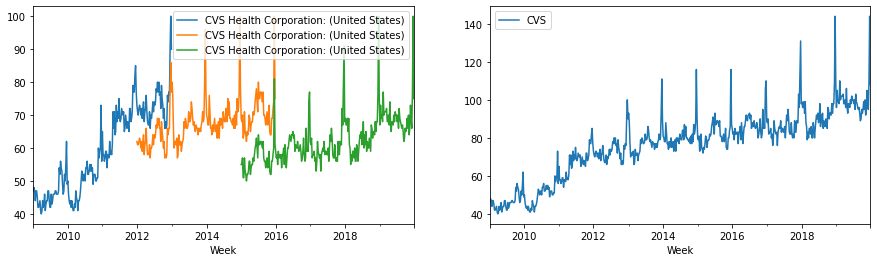

In [33]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
one.index = pd.to_datetime(one.index)
one.plot(ax = ax[0])
two.index = pd.to_datetime(two.index)
two.plot(ax = ax[0])
three.index = pd.to_datetime(three.index)
three.plot(ax = ax[0])
weekly_company.index = pd.to_datetime(weekly_company.index)
weekly_company.plot(ax = ax[1])
plt.show()

# 6. Scraping data from newspaper.com <a name="news"></a>



### 6.1 Collecting Data
In the first section we will see how the data have been collected using Selenium. The algorithm works as a series of for loop that will evaluate for every day of every year considered the number of matches in newspapers as provided from the webiste newspaper.com.
The code has been developed in such a way to handle of the peculiarities like the different number of days in each month and to take into account also the 29th of february in the case of leap years.

In [ ]:
#class to get all url according to the link given
class SelScraper():
    def __init__(self) -> None:
        self.option = webdriver.ChromeOptions()
        self.driver = webdriver.Chrome(executable_path="chromedriver.exe",options=self.option)
        self.driver.implicitly_wait(0.5)
        self.driver.maximize_window()

    def scrap_data(self):
        keyword_list = ['climate change','corporate governance','ESG','social responsibility','sustainability']
        year_list =[2009 + i for i in range(11)]
        month_dictionary ={
            "jan":31,
            "feb":28,
            "march":31,
            "april":30,
            "may":31,
            "june":30,
            "july":31,
            "aug":31,
            "sep":30,
            "oct":31,
            "nov":30,
            "dec":31
        }
        dates = []
        climate_changes = []
        corporate_governances = []
        ESGs = []
        social_responsibilities = []
        sustainability = []
        links = []
        for year in year_list:
            month_index = 1
            for  month in month_dictionary:
                if (year%4==0) and month=='feb':
                    days = 29
                else:
                    days = month_dictionary[month]
                if month_index < 10:
                    month = f"0{month_index}"
                else:
                    month = str(month_index)
                for day in range(1,days+1):
                    if day <10:
                        day = f"0{day}"
                    else:
                        day= str(day)
                    date = str(year) + '-' + month + '-' + day
                    dates.append(date)
                    for keyword in keyword_list:
                        temp_keyword = keyword.replace(' ','%20')
                        url = f'https://www.newspapers.com/search/?query={temp_keyword}&ymd={date}'
                        links.append(url)
                        self.driver.get(url)
                        print(url)
                        time.sleep(2)
                        matches_found = self.driver.find_element(By.TAG_NAME,'h1').find_element(By.TAG_NAME,'span').text
                        if 'Loading' in matches_found:
                            time.sleep(1)
                            matches_found = self.driver.find_element(By.TAG_NAME,'h1').find_element(By.TAG_NAME,'span').text
                        if 'Loading' in matches_found:
                            time.sleep(1)
                            matches_found = self.driver.find_element(By.TAG_NAME,'h1').find_element(By.TAG_NAME,'span').text
                        if keyword == 'climate change':
                            climate_changes.append(matches_found)
                        elif keyword =='corporate governance':
                            corporate_governances.append(matches_found)
                        elif keyword =='ESG':
                            ESGs.append(matches_found)
                        elif keyword =='social responsibility':
                            social_responsibilities.append(matches_found)
                        elif keyword =='sustainability':
                            sustainability.append(matches_found)
                        print(matches_found)
                month_index=month_index+1

        all_data = {
            "Date":dates,
            "climate change matches":climate_changes,
            "corporate governance matches":corporate_governances,
            "ESG matches":ESGs,
            "social responsibility matches":social_responsibilities,
            "sustainability matches":sustainability,
            }
        print(all_data)
        frame = pd.DataFrame(all_data)
        frame.to_csv('output.csv')
        self.close_driver()





    def close_driver(self):
        self.driver.close()

if "__main__"==__name__:
    obj = SelScraper()
    obj.scrap_data()


### 6.2 Formatting the data in csv files
Given time constraints The previous algorithm has been run on a yearly basis on different machines. Then we will have a csv file for each of the year that we took into consideraion. In the next two sections we will see how the data have been aggregated in two unique dataframes:
- daily_newspaper.csv: contains the matches for each of the keywords on a daily basis
- weekly_newspaper.csv: the data of daily_newspaper have been aggregated on a weeklt basis


#### 6.2.1 daily_newspaper


In [ ]:
import datetime as dt
df1 = pd.read_csv('Data/2009_output.csv')
df2 = pd.read_csv('Data/2010_output.csv')
df3 = pd.read_csv('Data/2011_output.csv')
df4 = pd.read_csv('Data/2012_output.csv')
df5 = pd.read_csv('Data/2013_output.csv')
df6 = pd.read_csv('Data/2014_output.csv')
df7 = pd.read_csv('Data/2015_output.csv')
df8 = pd.read_csv('Data/2016_output.csv')
df9 = pd.read_csv('Data/2017_output.csv')
df10 = pd.read_csv('Data/2018_output.csv')
df11 = pd.read_csv('Data/2019_output.csv')
final_df = df1.append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9).append(df10).append(df11)

In [ ]:
# substituing Loading and nan values with 0
final_df = final_df.replace('Loading', np.nan)
final_df = final_df.replace(np.nan, 0)
final_df.isnull().sum()  # no null

In [ ]:
final_df = final_df.drop('Unnamed: 0', axis=1).reset_index(drop=True)
final_df['Date'] = pd.to_datetime(final_df['Date'])


In [ ]:
final_df['WeekDate'] = final_df.apply(lambda row: row['Date'] - dt.timedelta(days=row['Date'].weekday()), axis=1)
final_df.drop('Date', axis=1)
final_df['climate change matches'] = final_df['climate change matches'].astype(float)
final_df['corporate governance matches'] = final_df['corporate governance matches'].astype(float)
final_df['ESG matches'] = final_df['ESG matches'].astype(float)
final_df['social responsibility matches'] = final_df['social responsibility matches'].astype(float)
final_df['sustainability matches'] = final_df['sustainability matches'].astype(float)

final_df.to_csv('daily_newspaper.csv')

In [ ]:
final_df.head()

#### 6.2.2 weekly_newspaper

In [ ]:
final_df.groupby('WeekDate').sum()
weekly_df = final_df.groupby('WeekDate').sum()

In [ ]:
weekly_df.to_csv('weekly_newspaper.csv')
